In [1]:
!pip install nlp transformers texttable &> /dev/null

In [2]:
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List
import re
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)  
from texttable import Texttable

from scipy.stats import pearsonr, entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, IterableDataset
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel, BertConfig, \
     AdamW, set_seed, AutoConfig, PreTrainedTokenizer, DataCollator, PreTrainedModel, PreTrainedTokenizer, DataCollator, PreTrainedModel

set_seed(23)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



 
## Processing Data, Defining Data Classes and Collator and other miscellaneous stuff



In [4]:
# Class to store data samples, text_a, text_b, score
@dataclass
class Example:
    text_a: str
    text_b: str
    score: float


# lowercase and add space around words, remove unnecessary spaces
def pre_process(sentence, cased=False):
    sentence = sentence.replace(":", " : ").replace("/", " / ").replace("[", " [ ").replace("]", " ] ").replace("(", " ( ").replace(")", " ) ").replace("\"", " \" ").replace("-", " - ").replace("?", " ").lstrip().rstrip()
    if cased:
      return re.sub(' +',' ', sentence)
    return re.sub(' +',' ', sentence).lower()


# returns test and train arrays as Example Objects
# test train split is stratified and 80-20 split
def get_data(cased=False, sent_type=None):
    train_data = "/content/drive/My Drive/clinical-sts/augmented_train.tsv"

    df = pd.read_csv(train_data, sep="\t", names=["sentence_1", "sentence_2", "similarity_score", "label"], encoding="utf-8")
    if sent_type == "CLINICAL":
        df = df[df["label"]=="CLINICAL"]
    elif sent_type == "MEDICAL":
        df = df[df["label"]=="MEDICAL"]

    df["sentence_1"] = df["sentence_1"].apply(lambda sentence: pre_process(sentence, cased))
    df["sentence_2"] = df["sentence_2"].apply(lambda sentence: pre_process(sentence, cased))
    df["input_sample"] = df["sentence_1"] + "<SEP>" + df["sentence_2"]

    ## stratified binned sampling
    min_val = np.amin(df["similarity_score"])
    max_val = np.amax(df["similarity_score"])
    bins     = np.linspace(start=min_val, stop=max_val, num=10)
    y_binned = np.digitize(df["similarity_score"], bins, right=True)

    X_train, X_test, y_train, y_test = train_test_split(
        df["input_sample"], 
        df["similarity_score"], 
        stratify=y_binned,
        test_size=0.2,
        random_state=23
    )

    train_a_b = [Example(text_a=sample.split("<SEP>")[0], 
                    text_b=sample.split("<SEP>")[1], 
                    score=similarity_score) for sample, similarity_score in zip(X_train, y_train)]
    train_b_a = [Example(text_a=sample.split("<SEP>")[1], 
                    text_b=sample.split("<SEP>")[0], 
                    score=similarity_score) for sample, similarity_score in zip(X_train, y_train)]
    train = train_a_b + train_b_a

    test_a_b = [Example(text_a=sample.split("<SEP>")[0], 
                    text_b=sample.split("<SEP>")[1], 
                    score=similarity_score) for sample, similarity_score in zip(X_test, y_test)]
    test_b_a = [Example(text_a=sample.split("<SEP>")[1], 
                    text_b=sample.split("<SEP>")[0], 
                    score=similarity_score) for sample, similarity_score in zip(X_test, y_test)]
    test = test_a_b + test_b_a

    return train, test




# DYNAMIC PADDING AND UNIFORM LENGTH BATCHING - reduces wasted computation and makes it faster to run
# CODE BORROWED FROM https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e


# We'll be creating a custome dataset using this first
@dataclass
class Features:
    og_sample: Example
    input_ids: List[int]
    attention_mask: List[int]
    score: float


class TextDataset(Dataset):
    def __init__(self, tokenizer, 
                 pad_to_max_length, 
                 max_len,
                 examples: List[Example]):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.examples: List[Example] = examples
        self.current = 0
        self.pad_to_max_length = pad_to_max_length

    # tokenize the sentences and return a Features object for each sentence 
    def encode(self, ex: Example) -> Features:
        encode_dict = self.tokenizer.encode_plus(text=ex.text_a,
                                                 text_pair=ex.text_b,
                                                 add_special_tokens=True,
                                                 max_length=self.max_len,
                                                 pad_to_max_length=self.pad_to_max_length,
                                                 return_token_type_ids=False,
                                                 return_attention_mask=True,
                                                 return_overflowing_tokens=False,
                                                 return_special_tokens_mask=False,
                                                 truncation=True,
                                                 )
        return Features(og_sample=ex,
                        input_ids=encode_dict["input_ids"],
                        attention_mask=encode_dict["attention_mask"],
                        score=ex.score)

    def __getitem__(self, idx) -> Features:
        return self.encode(ex=self.examples[idx])

    def __len__(self):
        return len(self.examples)


def pad_seq(seq: List[int], max_batch_len: int, pad_value: int) -> List[int]:
    return seq + (max_batch_len - len(seq)) * [pad_value]


# Smart Collator is used to create batches which are dynamically padded with uniform length 
@dataclass
class SmartCollator:  # (DataCollator):
    pad_token_id: int

    def collate_batch(self, batch: List[Features]) -> Dict[str, torch.Tensor]:
        batch_og_sample = list()
        batch_inputs = list()
        batch_attention_masks = list()
        labels = list()
        max_size = max([len(ex.input_ids) for ex in batch])
        for item in batch:
            batch_inputs += [pad_seq(item.input_ids, max_size, self.pad_token_id)]
            batch_attention_masks += [pad_seq(item.attention_mask, max_size, 0)]
            labels.append(item.score)
            batch_og_sample.append(item)

        return {"input_ids": torch.tensor(batch_inputs, dtype=torch.long),
                "attention_mask": torch.tensor(batch_attention_masks, dtype=torch.long),
                "score": torch.tensor(labels, dtype=torch.float),
                "og_sample": batch_og_sample
                }
                
def collate_wrapper(data):
    collator = SmartCollator(pad_token_id=tokenizer.pad_token_id)
    return collator.collate_batch(data)


# USE THIS FUNCTION TO LOAD TEST AND TRAIN DATA AND ITERATE THROUGH THEM
def load_data(tokenizer, batch_size, cased=False, sent_type=None):
    # Get train and test Data Examples
    train, test = get_data(cased, sent_type)


    # Now tokenize the words and convert them to token IDs
    max_sequence_len = 128
    train_set = TextDataset(tokenizer=tokenizer,
                            max_len=max_sequence_len,
                            examples=train,
                            pad_to_max_length=False)

    test_set = TextDataset(tokenizer=tokenizer,
                            max_len=max_sequence_len,
                            examples=test,
                            pad_to_max_length=False)

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_wrapper,
              pin_memory=False, drop_last=False, timeout=0,
              worker_init_fn=None)

    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_wrapper,
              pin_memory=False, drop_last=False, timeout=0,
              worker_init_fn=None)
    
    return train_dataloader, test_dataloader

##**Define the Training Loop for fine-tuning the Model.**  
We also have some miscellaneous functions to evaluate our model on the dev-set.  

  
    
The model is as shown below. We have different learning rates for the bert and LR layer. Note that we take the hidden layer output from BERT and not the CLS embedding. The CLS embedding does not generate any meaningful sentence embedding and BERT was specifically trained for the NSP task. As such, using the CLS embedding directly leads to worse results. We found that using the penultimate hidden layers gave us best results for this task.




In [5]:
# Let's define the training loop and model

def get_bert_output(my_bert, input_ids, attention_mask):    
    outputs = my_bert(input_ids, attention_mask=attention_mask)
    hidden_states = outputs[2]
    sent_embedding = hidden_states[11][:, 0:1, :].squeeze(1).cuda()
    return sent_embedding


class linearRegression(nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.linear = nn.Linear(768, 1)
    def forward(self, x):
        out = self.linear(x)
        return out

    
def run_new_method(my_bert, optimizer, regression_head, regression_optimizer, train_dataloader, test_dataloader, epochs=10, freeze_layers=False):
    old_test_loss = float('inf')

    # freeze_layers = "0,1,2,3,4"
    if freeze_layers:
        freeze_layers = "0,1,2,3,4,5"
        layer_indexes = [int(x) for x in freeze_layers.split(",")]
        for layer_idx in layer_indexes:
            for param in list(my_bert.encoder.layer[layer_idx].parameters()):
                param.requires_grad = False
            print ("Froze Layer: ", layer_idx)


    for epoch_num in range(epochs):
        total_loss = 0
        batch_count = 0
        # put model in train mode
        my_bert.train()
        regression_head.train()
        for step_num, batch_data in enumerate(train_dataloader):
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            score = batch_data["score"].to(device)
            score = score.unsqueeze(1)

            my_bert_optimizer.zero_grad()
            regression_optimizer.zero_grad()
            bert_embedding = get_bert_output(my_bert, input_ids, attention_mask)
            predicted_score = regression_head(bert_embedding)

            loss_func = nn.MSELoss()
            batch_loss = loss_func(predicted_score, score)

            
            batch_loss.backward()
            my_bert_optimizer.step()
            regression_optimizer.step()
            total_loss += batch_loss.item()
            batch_count += 1
            train_loss = total_loss/batch_count
        print("Epoch: {} Train Loss:{}".format(epoch_num, train_loss))

        # put model in test mode
        my_bert.eval()
        regression_head.eval()
        test_loss = 0
        test_batch_count = 0
        with torch.no_grad():
            for step_num, batch_data in enumerate(test_dataloader):
                input_ids = batch_data["input_ids"].to(device)
                attention_mask = batch_data["attention_mask"].to(device)
                score = batch_data["score"].to(device)
                score = score.unsqueeze(1)

                bert_embedding = get_bert_output(my_bert, input_ids, attention_mask)
                predicted_score = regression_head(bert_embedding)

                loss_func = nn.MSELoss()
                batch_loss = loss_func(predicted_score, score)
                test_loss += batch_loss.item()
                test_batch_count += 1
        # curr_test_loss = test_loss/test_batch_count
        # print("Epoch: {} Test Loss:{}\n".format(epoch_num, curr_test_loss))
        # if curr_test_loss < 0.61 or train_loss < 0.25:
        #     print("yay, exit")
        #     break
        curr_test_loss = test_loss/test_batch_count
        print("dev loss: {}\n".format(curr_test_loss))
        if curr_test_loss-old_test_loss >= 0.03 or curr_test_loss<0.61 or train_loss < 0.25:
            print("new test loss is greater; breaking")
            break
        old_test_loss = curr_test_loss
    return my_bert, regression_head




'''
    Method to evaluate and calculate pcc on dev/test dataset, and show terrible predictions
'''
def evaluate_model(model, regression_head, test_dataloader, show_bad_predictions=True, prediction_difference=2.0):

    actual = list()
    predicted = list()
    og_data = list()

    model.eval()
    with torch.no_grad():
        test_batch_count = 0
        test_loss =0
        for step_num, batch_data in enumerate(test_dataloader):
            input_ids = batch_data["input_ids"].to(device)
            attention_mask = batch_data["attention_mask"].to(device)
            score = batch_data["score"].to(device)
            score = score.unsqueeze(1)

            bert_embedding = get_bert_output(model, input_ids, attention_mask)
            predicted_score = regression_head(bert_embedding)

            actual.extend(score.tolist())
            predicted.extend(predicted_score.tolist())
            original_samples = batch_data["og_sample"]
            og_data.extend(original_samples)

    # show bad predictions in a table
    table = Texttable()
    table.add_row(["Actual", "Predicted", "Difference", "Text Sample"])

    for act, pre, og_data in zip(actual, predicted, og_data):
        if abs(pre[0]-act[0]) > prediction_difference:
            og = og_data.og_sample.text_a + "    |||    " + og_data.og_sample.text_b
            print("{:.2f}    {:.2f}          {:.2f}     {}".format(act[0], pre[0], abs(pre[0]-act[0]), og))

    print('\n\n\n')
    actual = [item[0] for item in actual]
    predicted = [item[0] for item in predicted]

    correlation, p_value = pearsonr(actual, predicted)
    print("Correlation score: ", correlation)
    r2_val = r2_score(actual, predicted)
    print("R2 Score: ", r2_val)



    d = {"a": actual, "p": predicted}
    dx = pd.DataFrame(d)
    dx.plot.hist(bins=20, alpha=0.25)
    return correlation


def get_optimizer_params(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    opt_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    return opt_parameters


In [ ]:
SENT_TYPE = "CLINICAL"
train_data, test_data = get_data(sent_type=SENT_TYPE)

d = {"Train Clinical": train_data, "Test Clinical": test_data}
dx = pd.DataFrame(d)
ax1 = dx.plot.hist(bins=20, alpha=0.25)
ax1.set_xlabel("Clinical Data Score Distribution")


SENT_TYPE = "MEDICAL"
train_data, test_data = get_data(sent_type=SENT_TYPE)
d = {"Train Clinical": train_data, "Test Clinical": test_data}
dx = pd.DataFrame(d)
ax1 = dx.plot.hist(bins=20, alpha=0.25)
ax1.set_xlabel("Medical Data Score Distribution")


## **Select the base model to fine tune, and pass it to the train loop**
We then evaluate the PCC on the dev set.  
Note: Only bad examples and scores are printed.

# BERT FINE TUNE ON CLINICAL

Epoch: 0 Train Loss:3.298357872057844
dev loss: 1.3038518281982225

Epoch: 1 Train Loss:1.0394384941017185
dev loss: 0.9704904159640565

Epoch: 2 Train Loss:0.7530986299531327
dev loss: 0.834207834347206

Epoch: 3 Train Loss:0.609519286343345
dev loss: 0.7518821424421143

Epoch: 4 Train Loss:0.5164313142222386
dev loss: 0.7156669142491677

Epoch: 5 Train Loss:0.45017093197891006
dev loss: 0.6987083650687161

Epoch: 6 Train Loss:0.39937123556931814
dev loss: 0.6929923291592037

Epoch: 7 Train Loss:0.36061688523601604
dev loss: 0.698101512320778

Epoch: 8 Train Loss:0.32712502791373815
dev loss: 0.6896761704017135

Epoch: 9 Train Loss:0.2837253684281475
dev loss: 0.6922246892662609

Epoch: 10 Train Loss:0.2660764479526767
dev loss: 0.6846528021509156

Epoch: 11 Train Loss:0.24206237842639286
dev loss: 0.676625757752096

new test loss is greater; breaking
3.00    -0.15          3.15     the patient is not currently experiencing numbness to the effected limb.    |||    the patient has inta

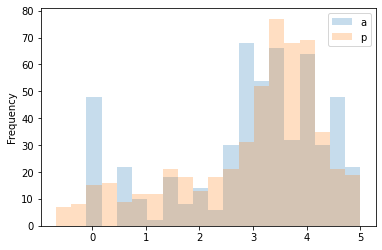

In [11]:
SENT_TYPE="CLINICAL"
MODEL = "bert-base-uncased"
my_bert = BertModel.from_pretrained(MODEL, output_hidden_states=True)
my_bert.cuda()

regression_head = linearRegression().cuda()
linear_regression_optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-5)


tokenizer = BertTokenizer.from_pretrained(MODEL, output_hidden_states=True)
train_dataloader, test_dataloader = load_data(tokenizer=tokenizer, batch_size=8, sent_type=SENT_TYPE)
bert_config = BertConfig.from_pretrained(MODEL, output_hidden_states=True)
my_bert_optimizer = AdamW(get_optimizer_params(my_bert), lr=1e-6)
updated_model, regression_head = run_new_method(my_bert=my_bert, optimizer=my_bert_optimizer, # optimizer
                                                regression_head=regression_head, 
                                                regression_optimizer=linear_regression_optimizer,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                epochs=15)

pcc = evaluate_model(updated_model, regression_head, test_dataloader)
model_loc = "/content/drive/My Drive/clinical-sts/models/{}-bert-{}-{:.4f}.pth".format(SENT_TYPE, MODEL, pcc)
regression_loc = "/content/drive/My Drive/clinical-sts/models/{}-regression-{}-{:.4f}.pth".format(SENT_TYPE, MODEL, pcc)
torch.save(updated_model, model_loc)
torch.save(regression_head, regression_loc)
print("Saved at:\n'{}'\n'{}'".format(model_loc, regression_loc))



# BERT FINE TUNE ON MEDICAL

Epoch: 0 Train Loss:1.0704144894099625
dev loss: 0.7635194063186646

Epoch: 1 Train Loss:0.5875688332026122
dev loss: 0.7165670283138752

Epoch: 2 Train Loss:0.4527077880062041
dev loss: 0.9039846509695053

new test loss is greater; breaking
3.00    0.79          2.21     metformin [ glucophage ] 500 mg tablet 1 - 2 tablets by mouth two times a day.    |||    furosemide 40 mg tablet 1 tablet by mouth one time daily.
3.00    0.77          2.23     furosemide 40 mg tablet 1 tablet by mouth one time daily.    |||    metformin [ glucophage ] 500 mg tablet 1 - 2 tablets by mouth two times a day.




Correlation score:  0.6022246804890707
R2 Score:  0.18653735494519164
Saved at:
'/content/drive/My Drive/clinical-sts/models/MEDICAL-bert-bert-base-uncased-0.60.pth'
'/content/drive/My Drive/clinical-sts/models/MEDICAL-regression-bert-base-uncased-0.60.pth'


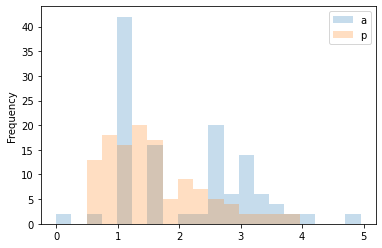

In [10]:
SENT_TYPE="MEDICAL"
MODEL = "bert-base-uncased"
my_bert = BertModel.from_pretrained(MODEL, output_hidden_states=True)
my_bert.cuda()

regression_head = linearRegression().cuda()
linear_regression_optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)


tokenizer = BertTokenizer.from_pretrained(MODEL, output_hidden_states=True)
train_dataloader, test_dataloader = load_data(tokenizer=tokenizer, batch_size=8, sent_type=SENT_TYPE)
bert_config = BertConfig.from_pretrained(MODEL, output_hidden_states=True)
my_bert_optimizer = AdamW(get_optimizer_params(my_bert), lr=1e-5)
updated_model, regression_head = run_new_method(my_bert=my_bert, optimizer=my_bert_optimizer, # optimizer
                                                regression_head=regression_head, 
                                                regression_optimizer=linear_regression_optimizer,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                epochs=5)

pcc = evaluate_model(updated_model, regression_head, test_dataloader)
model_loc = "/content/drive/My Drive/clinical-sts/models/{}-bert-{}-{:.2f}.pth".format(SENT_TYPE, MODEL, pcc)
regression_loc = "/content/drive/My Drive/clinical-sts/models/{}-regression-{}-{:.2f}.pth".format(SENT_TYPE, MODEL, pcc)
torch.save(updated_model, model_loc)
torch.save(regression_head, regression_loc)
print("Saved at:\n'{}'\n'{}'".format(model_loc, regression_loc))

# BIO-BERT FINE TUNE ON CLINICAL

Epoch: 0 Train Loss:1.2176987404900568
dev loss: 0.6022303312578622

new test loss is greater; breaking
4.50    2.10          2.40     alert and oriented x 3. pleasant and cooperative.    |||    neurological : he is oriented to person, place, and time.
3.00    0.52          2.48     the patient is not currently experiencing numbness to the effected limb.    |||    the patient has intact sensation to fine touch over the deltoid bilaterally.
2.00    4.53          2.53     patient's wife verbalized understanding and had no further questions or concerns at this time.    |||    no further questions or concerns at this time.
4.50    2.47          2.03     the past medical history, medications, allergies, family history and social history were reviewed and are present in the emr.    |||    the following portions of the patient's history were reviewed and updated as appropriate : social history, surgical history and problem list.
3.45    1.32          2.13     goals : patient will demonstrate 

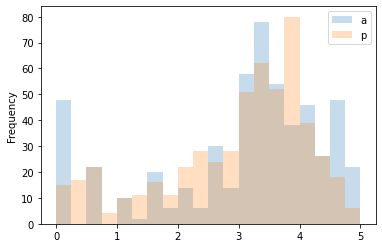

In [19]:
SENT_TYPE="CLINICAL"
MODEL = "/content/drive/My Drive/clinical-sts/bio-bert/"
my_bert = BertModel.from_pretrained(MODEL, output_hidden_states=True)
my_bert.cuda()

regression_head = linearRegression().cuda()
linear_regression_optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)


tokenizer = AutoTokenizer.from_pretrained(MODEL, output_hidden_states=True)
train_dataloader, test_dataloader = load_data(tokenizer=tokenizer, batch_size=8, sent_type=SENT_TYPE)
bert_config = BertConfig.from_pretrained(MODEL, output_hidden_states=True)
my_bert_optimizer = AdamW(get_optimizer_params(my_bert), lr=1e-5)
updated_model, regression_head = run_new_method(my_bert=my_bert, optimizer=my_bert_optimizer, # optimizer
                                                regression_head=regression_head, 
                                                regression_optimizer=linear_regression_optimizer,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                epochs=3)

pcc = evaluate_model(updated_model, regression_head, test_dataloader)
model_name = "bio-bert"
model_loc = "/content/drive/My Drive/clinical-sts/models/{}-bert-{}-{:.2f}.pth".format(SENT_TYPE, model_name, pcc)
regression_loc = "/content/drive/My Drive/clinical-sts/models/{}-regression-{}-{:.2f}.pth".format(SENT_TYPE, model_name, pcc)
torch.save(updated_model, model_loc)
torch.save(regression_head, regression_loc)
print("Saved at:\n'{}'\n'{}'".format(model_loc, regression_loc))

# BIO-BERT FINE TUNE ON MEDICAL

Epoch: 0 Train Loss:1.2410147082610208
dev loss: 0.7762654032558203

Epoch: 1 Train Loss:0.6183263180685825
dev loss: 0.6620215158909559

Epoch: 2 Train Loss:0.4827575686036563
dev loss: 0.6456039138138294





Correlation score:  0.6537074888172552
R2 Score:  0.40395896874296544
Saved at:
'/content/drive/My Drive/clinical-sts/models/MEDICAL-bert-bio-bert-0.65.pth'
'/content/drive/My Drive/clinical-sts/models/MEDICAL-regression-bio-bert-0.65.pth'


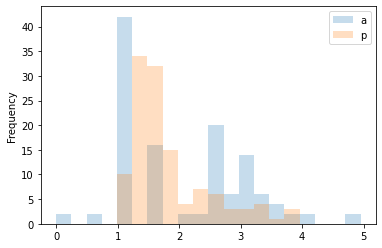

In [23]:
SENT_TYPE="MEDICAL"
MODEL = "/content/drive/My Drive/clinical-sts/bio-bert/"
my_bert = BertModel.from_pretrained(MODEL, output_hidden_states=True)
my_bert.cuda()

regression_head = linearRegression().cuda()
linear_regression_optimizer = torch.optim.Adam(regression_head.parameters(), lr=1e-4)


tokenizer = AutoTokenizer.from_pretrained(MODEL, output_hidden_states=True)
train_dataloader, test_dataloader = load_data(tokenizer=tokenizer, batch_size=8, sent_type=SENT_TYPE)
bert_config = BertConfig.from_pretrained(MODEL, output_hidden_states=True)
my_bert_optimizer = AdamW(get_optimizer_params(my_bert), lr=1e-5)
updated_model, regression_head = run_new_method(my_bert=my_bert, optimizer=my_bert_optimizer, # optimizer
                                                regression_head=regression_head, 
                                                regression_optimizer=linear_regression_optimizer,
                                                train_dataloader=train_dataloader,
                                                test_dataloader=test_dataloader,
                                                epochs=3)

pcc = evaluate_model(updated_model, regression_head, test_dataloader)
model_name = "bio-bert"
model_loc = "/content/drive/My Drive/clinical-sts/models/{}-bert-{}-{:.2f}.pth".format(SENT_TYPE, model_name, pcc)
regression_loc = "/content/drive/My Drive/clinical-sts/models/{}-regression-{}-{:.2f}.pth".format(SENT_TYPE, model_name, pcc)
torch.save(updated_model, model_loc)
torch.save(regression_head, regression_loc)
print("Saved at:\n'{}'\n'{}'".format(model_loc, regression_loc))